# validating `sbi`
In this notebook we'll go through SBI validation techniques such as simulation-based calibration, coverage tests, and TARP 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import corner

In [2]:
import torch

import sbi
from sbi.utils import BoxUniform
from sbi.inference import NPE

In [3]:
np.random.seed(1)

# Example 1
Let's go straight into the example of fitting a line to some data. This is the same example as previous notebooks.

In [4]:
a_true, b_true = 0, 1.75
x = np.array([1, 1.5, 2, 2.5])
y = np.array([1.87640523, 2.59001572, 3.4978738 , 4.47408932])
yerr = 0.1

<ErrorbarContainer object of 3 artists>

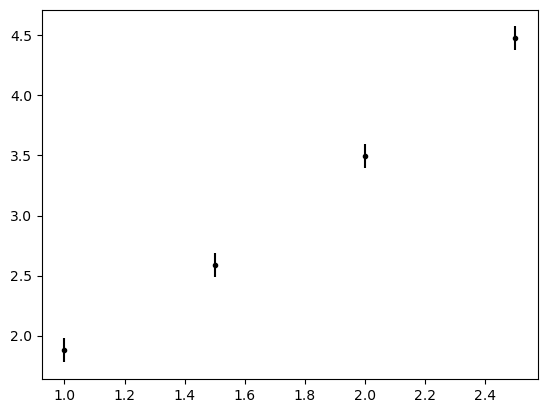

In [5]:
plt.errorbar(x, y, yerr=yerr, fmt='.k')

In [6]:
def simulation(theta): 
    a, b = theta
    noise = yerr * np.random.normal(size=len(x))
    return a + b * x + noise

def sample_prior(): 
    # sample a and b from uniform prior
    _a = -0.5 + np.random.normal() 
    _b = 5 + 3*np.random.normal()
    return [_a, _b]

same as above, sample $(\theta', \mathcal{D}') \sim p(\theta, \mathcal{D})$

In [7]:
Nsample = 500000

samples = np.zeros((Nsample, 6))
for i in range(Nsample): 
    theta_p = sample_prior()
    data_p = simulation(theta_p)
    samples[i,:] = np.concatenate([theta_p, data_p])
samples = torch.tensor(samples, dtype=torch.float32)

In [8]:
_range = BoxUniform(low=torch.tensor([-10., -10], dtype=torch.float32), high=torch.tensor([10., 100.], dtype=torch.float32))

maf = NPE(_range, density_estimator='maf')

# append (theta, D) from the simulations
_ = maf.append_simulations(samples[:,:2], samples[:,2:])
# train NPE. 
npe_maf = maf.train()
posterior_maf = maf.build_posterior()

 Neural network successfully converged after 64 epochs.

In [9]:
q_samples = posterior_maf.sample((10000,), x=torch.tensor(y, dtype=torch.float32))

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_6243/2934160455.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(q_samples.cpu()), labels=['a', 'b'])


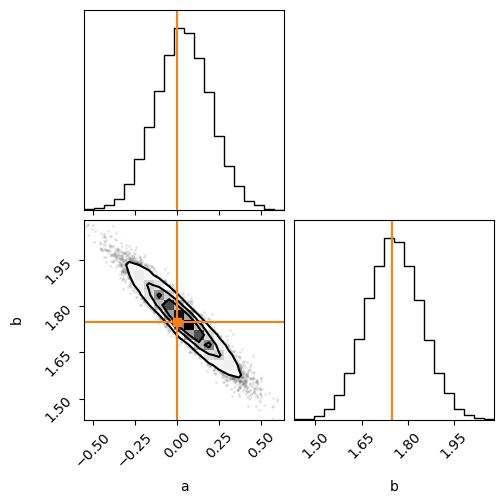

In [10]:
fig = corner.corner(np.array(q_samples.cpu()), labels=['a', 'b'])
corner.overplot_lines(fig, [a_true, b_true], color="C1")
corner.overplot_points(fig, np.array([a_true, b_true])[None], marker="s", color="C1")

## construct test simulations
For Bayesian inference, the test simulations must be constructing using $\theta$ sample from the same prior. 

In [11]:
Ntest = 1000

theta_test = np.zeros((Ntest, 2))
data_test = np.zeros((Ntest, 4))
for i in range(Ntest): 
    theta_p = sample_prior()
    data_p = simulation(theta_p)
    
    theta_test[i,:] = theta_p
    data_test[i,:] = data_p 
    
theta_test = torch.tensor(theta_test, dtype=torch.float32)
data_test = torch.tensor(data_test, dtype=torch.float32)

## simulation-based calibration (SBC)
Let's start with SBC. The algorithm is simple: 

```
for theta_test, data_test in test_samples: 

    # Draw posterior samples θ^(1:S) ~ q(θ | x)
    q_samples = NPE(data_test)

    # compute rank 
    rank = sum(q_samples < theta_test)
```

In [12]:
ranks_a = []
ranks_b = [] 

for _theta, _data in zip(theta_test, data_test): 
    _q_samples = posterior_maf.sample((1000,), x=torch.tensor(_data, dtype=torch.float32), show_progress_bars=False)

    # calculate rank for each dimension
    ranks_a.append(np.sum(_q_samples.numpy()[:,0] < _theta.numpy()[0])) 
    ranks_b.append(np.sum(_q_samples.numpy()[:,1] < _theta.numpy()[1])) 

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_6243/3887075485.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _q_samples = posterior_maf.sample((1000,), x=torch.tensor(_data, dtype=torch.float32), show_progress_bars=False)


(0.0, 130.0)

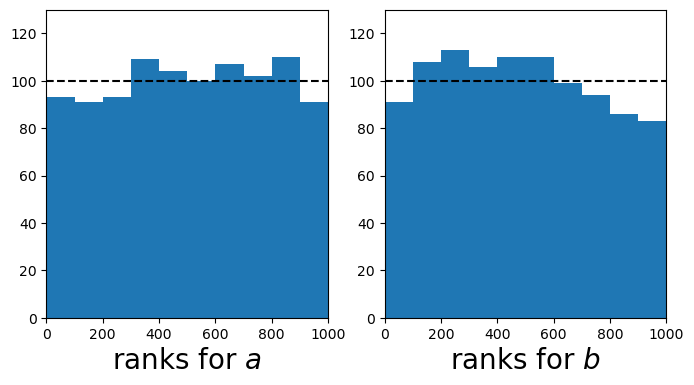

In [13]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)
_ = sub.hist(ranks_a, range=(0, 1000), bins=10)
sub.axhline(Ntest/10, color='k', linestyle='--')
sub.set_xlabel('ranks for $a$', fontsize=20)
sub.set_xlim(0, 1000)
sub.set_ylim(0., 1.3*Ntest/10)

sub = fig.add_subplot(122)
sub.hist(ranks_b, range=(0, 1000), bins=10)
sub.axhline(Ntest/10, color='k', linestyle='--')
sub.set_xlabel('ranks for $b$', fontsize=20)
sub.set_xlim(0, 1000)
sub.set_ylim(0., 1.3*Ntest/10)

SBC shows that $q_\phi$ is pretty reasonable. The posterior on $a$ may be slightly overconfident. 

## probability-probability coverage plot
For the PP plot, we only need to modify the rank statistic to estimate coverage

```
for theta_test, data_test in test_samples: 

    # Draw posterior samples θ^(1:S) ~ q(θ | x)
    q_samples = NPE(data_test)

    # estimate coverage 
    coverage = quantile(q_samples, theta_test)
```

In [14]:
hist_a, _ = np.histogram(np.array(ranks_a) / Ntest, range=(0., 1.), bins=100)
cdf_a = np.cumsum(hist_a) / Ntest

hist_b, _ = np.histogram(np.array(ranks_b) / Ntest, range=(0., 1.), bins=100)
cdf_b = np.cumsum(hist_b) / Ntest

(0.0, 1.0)

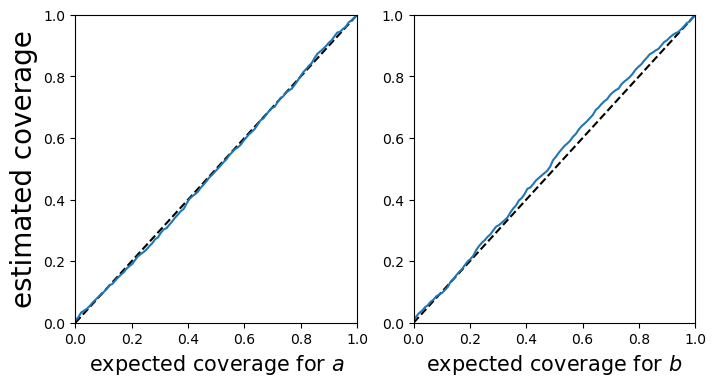

In [15]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)
sub.plot([0., 1.], [0., 1.], c='k', ls='--')
sub.plot(np.linspace(0., 1., 100), cdf_a)
sub.set_xlabel('expected coverage for $a$', fontsize=15)
sub.set_xlim(0, 1.)
sub.set_ylabel('estimated coverage', fontsize=20)
sub.set_ylim(0., 1.)

sub = fig.add_subplot(122)
sub.plot([0., 1.], [0., 1.], c='k', ls='--')
sub.plot(np.linspace(0., 1., 100), cdf_b)
sub.set_xlabel('expected coverage for $b$', fontsize=15)
sub.set_xlim(0, 1.)
sub.set_ylim(0., 1.)

# Tests of Accuracy with Random Points (TARP) coverage
The validation above were for the 1D marginal posteriors for $a$ and $b$ separately. Now lets try TARP using their python package: [`tarp`](https://github.com/Ciela-Institute/tarp)

In [16]:
import tarp

In [22]:
q_samp = [] 
for _theta, _data in zip(theta_test, data_test): 
    _q_samples = posterior_maf.sample((1000,), x=torch.tensor(_data, dtype=torch.float32), show_progress_bars=False)
    q_samp.append(_q_samples)
q_samp = np.array(q_samp)

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_6243/3396562450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _q_samples = posterior_maf.sample((1000,), x=torch.tensor(_data, dtype=torch.float32), show_progress_bars=False)


In [24]:
ecp, alpha = tarp.get_tarp_coverage(q_samp, theta_test.numpy(), references="random", metric="euclidean")

(0.0, 1.0)

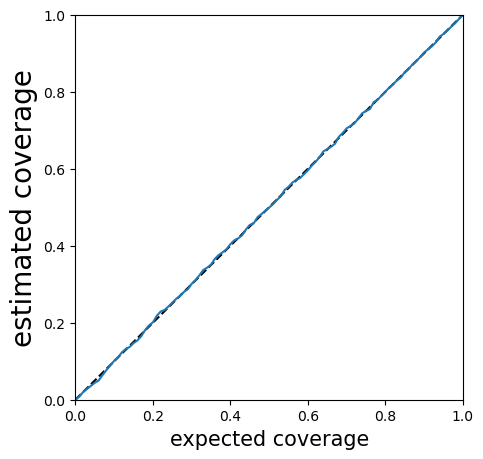

In [25]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.plot([0., 1.], [0., 1.], c='k', ls='--')
sub.plot(alpha, ecp)
sub.set_xlabel('expected coverage', fontsize=15)
sub.set_xlim(0, 1.)
sub.set_ylabel('estimated coverage', fontsize=20)
sub.set_ylim(0., 1.)